In [26]:
import os
from tabulate import tabulate
from nilearn import plotting
from nilearn import image
from nilearn.image import math_img, resample_to_img, get_data
from nilearn.datasets import fetch_atlas_harvard_oxford
from nilearn.plotting import plot_stat_map, view_img
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp, pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import ants
import nibabel as nib

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (182, 218, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-91.0, -126.0, -72.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [ ]:
# Fetch the Harvard-Oxford atlas
ATLAS = fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')
# Load the atlas image
ATLAS_IMAGE = image.load_img(ATLAS.maps)
ATLAS_DATA = get_data(ATLAS_IMAGE)
# Extract region names from the atlas
LABEL_NAMES = ATLAS['labels']
# Extract unique region labels from the atlas
REGION_LABELS = np.unique(ATLAS_DATA)

[get_dataset_dir] Dataset found in /Users/mayerunterberg/nilearn_data/fsl


In [3]:
def get_subject_file_pairs(data_dir, subjectDF):
    file_pairs = []
    for subject in os.listdir(data_dir):
        subject_path = os.path.join(data_dir, subject)

        # Skip non-directories or irrelevant files
        if not os.path.isdir(subject_path) or subject.startswith('.') or subject == 'derivatives':
            continue

        for index, row in subjectDF.iterrows():
            subject = row['participant_id']
            subject_path = os.path.join(data_dir, f"sub-{subject:03d}")

            # Locate BL and FU files
            baseline_file = os.path.join(subject_path, 'ses-BL', 'anat', f"sub-{subject:03d}_ses-BL_T1w.nii.gz")
            followup_file = os.path.join(subject_path, 'ses-FU', 'anat', f"sub-{subject:03d}_ses-FU_T1w.nii.gz")

            # Verify that both files exist
            if os.path.exists(baseline_file) and os.path.exists(followup_file):
                # Add the file paths to the DataFrame
                subjectDF.at[index, 'Baseline File Path'] = 'Data/' + os.path.relpath(baseline_file, data_dir)
                subjectDF.at[index, 'Followup File Path'] = 'Data/' + os.path.relpath(followup_file, data_dir)
            else:
                print(f"Skipping subject {subject}: missing files.")

In [59]:
def nifti_to_ants(nifti_img):
    # Extract voxel data, spacing, and origin from the NIfTI image
    voxel_data = nifti_img.get_fdata()  # Get voxel data
    affine = nifti_img.affine  # Get affine matrix
    spacing = tuple(np.linalg.norm(affine[:3, :3], axis=0))  # Compute voxel spacing
    origin = tuple(affine[:3, 3])  # Extract origin (translation)
    
    # Convert to ANTs image
    ants_image = ants.from_numpy(voxel_data, origin=origin, spacing=spacing)
    return ants_image

def register_and_convert_to_nifti(fixed_image, moving_image, transform_type='Rigid'):
    # Perform the registration
    registered = ants.registration(
        fixed=fixed_image,
        moving=moving_image,
        type_of_transform=transform_type
    )['warpedmovout']

    # Extract voxel data and spacing from the registered image
    voxel_data = registered.numpy()  # Voxel data as NumPy array
    spacing = registered.spacing  # Voxel spacing (dx, dy, dz)
    origin = registered.origin  # Image origin (x, y, z)
    
    # Construct a 4x4 affine matrix
    affine = np.eye(4)  # Identity matrix
    affine[:3, :3] = np.diag(spacing)  # Set voxel spacing
    affine[:3, 3] = origin  # Set translation (origin)
    # Create and return a NIfTI image
    return nib.Nifti1Image(voxel_data, affine)

def loadImage(imgPath):
    atlas_nifti = ATLAS['maps']
    # Convert the atlas NIfTI to an ANTs image
    atlas_image = nifti_to_ants(atlas_nifti)
    # Load the moving image and convert to an ANTs image
    img_nifti = nib.load(imgPath)
    img_image = nifti_to_ants(img_nifti)

    # Register and convert to NIfTI
    nifti = register_and_convert_to_nifti(fixed_image=atlas_image, moving_image=img_image)

    # Resample and smooth the NIfTI image
    img_resampled = resample_to_img(
        source_img=nifti,
        target_img=ATLAS_IMAGE,
        force_resample=True,
        copy_header=True,
        interpolation='nearest'
    )
    img = resample_to_img(source_img=nifti, target_img=ATLAS_IMAGE, force_resample=True, copy_header=True, interpolation='nearest')
    img = image.smooth_img(img, fwhm=6)
    return img

def findDifferingAreas(index, regionList, img1, img2):
    # Creates the difference map
    diff = image.math_img("img1 - img2", img1=img1, img2=img2)
    diff_data = get_data(diff)
    # Loop through each region to compute statistics
    for label in REGION_LABELS:
        regionMask = (ATLAS_DATA == label)
        regionChanges = diff_data[regionMask]
        region_mean = round(float(np.mean(regionChanges)), 2)
        if 0 <= label < len(LABEL_NAMES):
            region_name = LABEL_NAMES[label]  # Adjust for 1-based indexing
        else:
            region_name = "Unknown Region"
        # Insert the region_mean into the correct column and row in the DataFrame
        participants_df.loc[index, f"{region_name} Change"] = region_mean

In [5]:
participants_df = pd.read_csv('Data/participants.tsv', sep="\t")
# Add columns for file paths
filePaths = ['Baseline File Path', 'Followup File Path']
for label in filePaths:
    participants_df[label] = None
get_subject_file_pairs('Data', participants_df)
for label in LABEL_NAMES:
    participants_df[label + ' Change'] = None

,40
participant_id,132
group,CB
gender,male
age at baseline,19.03
age at onset first CB use,12.0
...,...
Planum Polare Change,33.33
Heschl's Gyrus (includes H1 and H2) Change,-126.39
Planum Temporale Change,-219.44
Supracalcarine Cortex Change,-365.96


In [6]:
for index, row in participants_df.iterrows():
    baseLinePath = participants_df.loc[index,'Baseline File Path']
    followUpPath = participants_df.loc[index,'Followup File Path']
    baseLine = loadImage(baseLinePath)
    followUp = loadImage(followUpPath)
    findDifferingAreas(index, participants_df, baseLine, followUp)
    
participants_df = participants_df.drop(columns=['Baseline File Path', 'Followup File Path'])

In [30]:
import subprocess
output_excel_path = 'participants_with_changes_test.xlsx'
participants_df.to_excel(output_excel_path, index=False)
subprocess.run(["open", output_excel_path])

CompletedProcess(args=['open', 'participants_with_changes_test.xlsx'], returncode=0)

In [6]:
participants_df['avg cudit'] = (participants_df['cudit total baseline'] + participants_df['cudit total follow-up']) / 2
cudit_columns = ['avg cudit']
brain_region_columns = [col for col in participants_df.columns if 'Change' in col]
# Combine into one dataset
correlation_data = participants_df[cudit_columns + brain_region_columns]
# Compute correlations
correlation_matrix = correlation_data.corr()
cudit_correlations = correlation_matrix.loc[cudit_columns, brain_region_columns]
#cudit_correlations.T.sort_values(by='avg cudit', ascending=False)

In [66]:
bu = participants_df[participants_df['participant_id'] == 202]['Baseline File Path'].iloc[0]
fu = participants_df[participants_df['participant_id'] == 202]['Followup File Path'].iloc[0]
baseLine = loadImage(bu)
followUp = loadImage(fu)
findDifferingAreas(0, participants_df, baseLine, followUp)

In [67]:
participants_df[participants_df['participant_id'] == 202]

,participant_id,group,gender,age at baseline,age at onset first CB use,age at onset frequent CB use,cudit total baseline,cudit total follow-up,audit total baseline,audit total follow-up,...,Occipital Fusiform Gyrus Change,Frontal Opercular Cortex Change,Central Opercular Cortex Change,Parietal Opercular Cortex Change,Planum Polare Change,Heschl's Gyrus (includes H1 and H2) Change,Planum Temporale Change,Supracalcarine Cortex Change,Occipital Pole Change,avg cudit
0,202,HC,female,25.62,18.0,NaN,1,0,6,3,...,-134.96,-287.14,-411.33,-635.61,-267.54,-530.41,-626.04,-319.52,-158.84,0.5


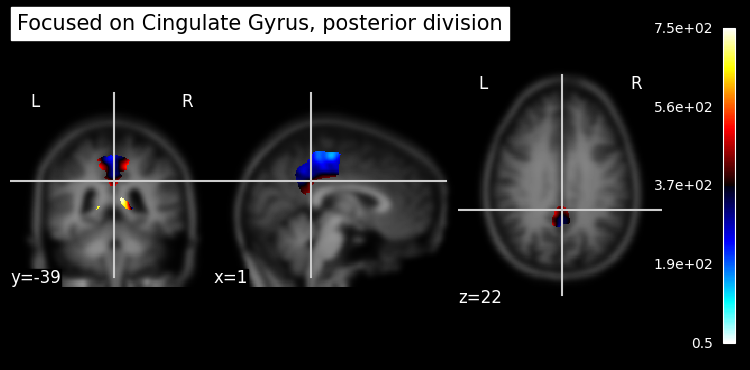

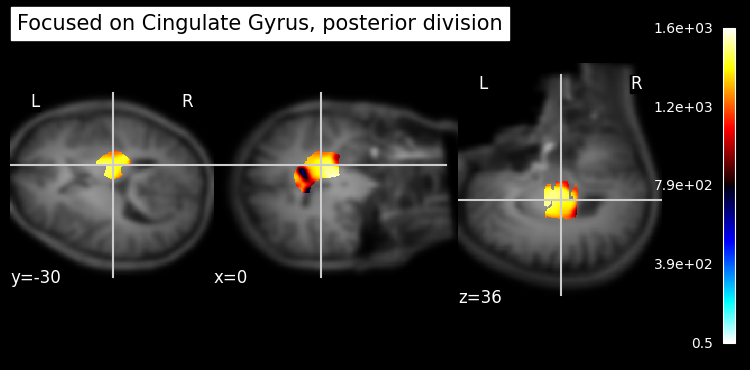

In [69]:
from nilearn.image import new_img_like

# Select a specific region by label
region_label = 'Cingulate Gyrus, posterior division'  # Replace with your region of interest
region_index = LABEL_NAMES.index(region_label)

# Remove the singleton dimension
stat_map = new_img_like(baseLine, baseLine.get_fdata().squeeze())
region_mask = math_img('img == ' + str(region_index), img=ATLAS_IMAGE)
roi_stat_map = math_img("stat_map * mask", stat_map=stat_map, mask=region_mask)
plot_stat_map(roi_stat_map, bg_img=baseLine, title=f"Focused on {region_label}", threshold=0.5)

stat_map = new_img_like(followUp, followUp.get_fdata().squeeze())
region_mask = math_img('img == ' + str(region_index), img=ATLAS_IMAGE)
roi_stat_map = math_img("stat_map * mask", stat_map=stat_map, mask=region_mask)
plot_stat_map(roi_stat_map, bg_img=followUp, title=f"Focused on {region_label}", threshold=0.5)


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__']
